### Synthetic data generation: overview and config
- Goal: create clustered synthetic vectors, visualize with UMAP, and produce ground-truth nearest neighbors for benchmarking.
- Overall flow:
  - Generate/learn centroids (cuVS K-Means on a pool), save once
  - Generate sharded blobs around centroids (varying std), split base vs queries
  - Build centroid BF index; for each query shard: find top-C nearest centroids
  - Stream only candidates from those centroids; brute-force kNN; merge top-k
  - Save GT distances/labels/point_ids; optionally visualize UMAP; validate GT

In [2]:
# total vectors that you want to generate
total_vectors = 10_000_000_000

# total vectors per centroid
vectors_per_centroid = 156_250

# total number of centroid
total_centroids = total_vectors // vectors_per_centroid
print(f"total_centroids: {total_centroids}")

# dimension of the vectors
dim = 128

# output precision: 'fp32' | 'fp16' | 'int'
precision = 'fp32'

# integer dtype if precision == 'int': 'int8' | 'uint8' | 'int16' | 'int32'
int_dtype = 'int8'

# scale factor for int quantization (normal * scale -> clip -> cast)
int_scale = 16.0

# batched centroid generation to avoid OOM; shards saved if needed
centroid_batch_size = 1_000_000

# per make_blobs batch, number of query points to sample and save
total_queries = 10_000

# ground-truth params
top_c_centroids = 10
gt_k = 10

# directory for sharded centroids when num_centroids > centroid_batch_size
save_dir = "/raid/data/synth"

#total vectors for training centroids
max_centroids_pool_size = total_centroids*200


total_centroids: 64000


### Generate centroids with cuVS K-Means (then casting)
- Learn `total_centroids × dim` centroids using cuVS K-Means on a pool of size `min(3_000_000, total_vectors)` sampled from N(0,1)`; keep these fixed for all downstream generation.
- This yields space-filling centroids (vs i.i.d. normals) and prints K-Means timing for visibility.
- `cast(x)` enforces the output `precision`:
  - `fp32` / `fp16` float
  - `int*` quantized with `int_scale`, clipped to target integer dtype.
- Centroids are saved under `save_dir/centroids/` as a single file or shard series.


In [ ]:
import os, time, cupy as cp
from cuvs.cluster import kmeans as cuvs_kmeans
cp.random.seed(42)

nc, D = int(total_centroids), int(dim)
fp = {'fp32': cp.float32, 'fp16': cp.float16}.get(precision)
int_dt = {'int8': cp.int8, 'uint8': cp.uint8, 'int16': cp.int16, 'int32': cp.int32}.get(int_dtype, cp.int8)

os.makedirs(f"{save_dir}/centroids", exist_ok=True)

def cast(x):
    if precision == 'int':
        info = cp.iinfo(int_dt)
        return cp.clip(cp.rint(x * float(int_scale)), info.min, info.max).astype(int_dt)
    return x.astype(fp or cp.float32)

pool_n = min(max_centroids_pool_size, int(total_vectors))
X_pool = cp.random.normal(0, 1, (pool_n, D), dtype=cp.float32)

# Fit cuVS KMeans (params first)
t0 = time.perf_counter()
params = cuvs_kmeans.KMeansParams(n_clusters=nc)
km_res = cuvs_kmeans.fit(params, X_pool)
C = getattr(km_res, 'centroids', km_res[0])
t1 = time.perf_counter()

C = cp.asarray(C, dtype=cp.float32)
cp.save(f"{save_dir}/centroids/centroids.npy", cast(C))
print(f"[cuVS KMeans] pool={pool_n:,} k={nc} dim={D} time={t1 - t0:.2f}s -> {save_dir}/centroids/centroids.npy")

### Generate blobs + queries (GPU-first)
- For each centroid shard, synthesize `vectors_per_centroid` samples per centroid with `cuml.datasets.make_blobs` and per-centroid stddev.
- Compute `global_labels` as centroid ids offset by shard start.
- Split each batch into:
  - Base vectors: saved as `blobs_s*_n*.npy` and `*.labels.npy`.
  - Query vectors: saved as `*.queries.npy` and `*.queries.labels.npy` (disjoint from base).
- Apply `cast` to enforce `precision` (`fp32`, `fp16`, or quantized `int*`).


In [62]:
# Generate blobs around centroids with random stddev (batched, GPU-first)
import os, cupy as cp, time
cp.random.seed(42)
gpu=False

if gpu:
    from cuml.datasets import make_blobs as mk
else:    
    from sklearn.datasets import make_blobs as mk


D=int(dim); k_per=int(vectors_per_centroid); sb=1_000_000
out_dir=f"{save_dir}/blobs"; os.makedirs(out_dir, exist_ok=True)

def centers_iter():
    if 'centroids' in globals():
        yield centroids, 0
    elif os.path.exists(f"{save_dir}/centroids/centroids.npy"):
        yield cp.load(f"{save_dir}/centroids/centroids.npy"), 0
    else:
        cdir=f"{save_dir}/centroids"
        for p in sorted([p for p in os.listdir(cdir) if p.endswith('.npy')]):
            s=int(p.split('_s')[1].split('_')[0]); yield cp.load(f"{cdir}/{p}"), s

def cast(x):
    try:
        return globals()['cast'](x)
    except Exception:
        if precision=='int':
            dt={'int8':cp.int8,'uint8':cp.uint8,'int16':cp.int16,'int32':cp.int32}[int_dtype]
            info=cp.iinfo(dt); return cp.clip(cp.rint(x*float(int_scale)), info.min, info.max).astype(dt)
        return x.astype(cp.float16 if precision=='fp16' else cp.float32)

# Pre-compute shard count to distribute queries evenly across shards
num_shards_total = 0
for C_tmp, _ in centers_iter():
    m_tmp = max(1, sb // k_per)
    num_shards_total += (len(C_tmp) + m_tmp - 1) // m_tmp

q_total = int(total_queries)
q_per_shard = q_total // max(1, num_shards_total)
if q_total % max(1, num_shards_total) != 0:
    print(f"[blobs] total_queries={q_total} not divisible by shards={num_shards_total}; using per-shard={q_per_shard} -> total={q_per_shard*num_shards_total}")

start_total = time.perf_counter(); num_shards = 0
shard_id = 0
for C, base in centers_iter():
    m=max(1, sb//k_per)
    print(f"[blobs] D={D} k_per={k_per} sb={sb} m={m}")
    for s in range(0, len(C), m):
        t0 = time.perf_counter()
        Cb=C[s:s+m]; stds=cp.random.uniform(0.05,0.5, len(Cb))
        n=k_per*len(Cb)
        if gpu:
            X,y=mk(n_samples=n, n_features=D, centers=Cb, cluster_std=stds, random_state=42)
            X=cp.asarray(X); y=cp.asarray(y, dtype=cp.int32)
        else:
            import numpy as np
            X,y=mk(n_samples=n, n_features=D, centers=cp.asnumpy(Cb), cluster_std=cp.asnumpy(stds), random_state=42)
            X=cp.asarray(X); y=cp.asarray(y, dtype=cp.int32)
        global_labels = y + (base + s)
        shard = f"{out_dir}/blobs_s{shard_id:012d}_n{n:012d}"
        # Split into base and queries (disjoint)
        q = int(min(q_per_shard, n))
        q_idx = cp.random.permutation(n)[:q]
        mask = cp.ones(n, dtype=cp.bool_); mask[q_idx] = False
        base_idx = cp.nonzero(mask)[0]
        # Save base shard (queries removed)
        cp.save(f"{shard}.npy", cast(X[base_idx]))
        cp.save(f"{shard}.labels.npy", global_labels[base_idx])
        # Save queries
        cp.save(f"{shard}.queries.npy", cast(X[q_idx]))
        cp.save(f"{shard}.queries.labels.npy", global_labels[q_idx])
        num_shards += 1
        print(f"[blobs] shard={shard_id} n={n} q={q} time={time.perf_counter()-t0:.2f}s")
        shard_id += 1
print(f"[blobs] total_shards={num_shards} total_time={time.perf_counter()-start_total:.2f}s")


[blobs] total_queries=10000 not divisible by shards=6; using per-shard=1666 -> total=9996
[blobs] D=128 k_per=78 sb=1000000 m=12820


[blobs] shard=0 n=999960 q=1666 time=4.76s
[blobs] shard=1 n=999960 q=1666 time=4.77s
[blobs] shard=2 n=999960 q=1666 time=4.76s
[blobs] shard=3 n=999960 q=1666 time=4.76s
[blobs] shard=4 n=999960 q=1666 time=4.76s
[blobs] shard=5 n=156 q=156 time=0.01s
[blobs] total_shards=6 total_time=23.83s


# Visualize the synthetic data with UMAP-

### UMAP preview (sampled subset on GPU)
- Randomly sample up to `sample_size` vectors across blob shards (capped per-shard) using CPU memmaps.
- Move samples to GPU (`cupy`) and run `cuml.manifold.UMAP` to 2D.
- Visualize with matplotlib, colored by sampled blob shard id; if plotting unavailable, save:
  - `umap_2d.npy` and `umap_labels.npy` under `save_dir`.


[2025-12-07 15:32:28.710] [CUML] [info] build_algo set to brute_force_knn because random_state is given


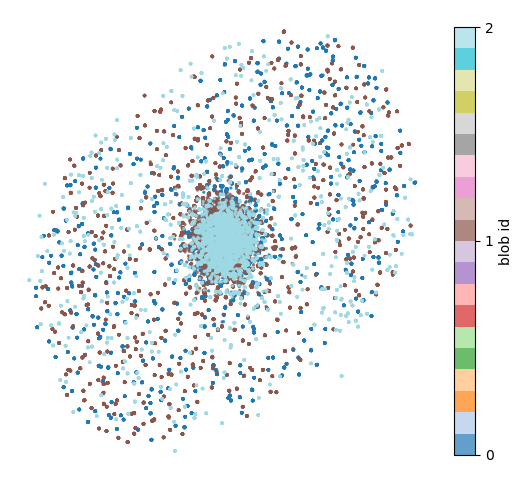

In [53]:
# UMAP visualization on a subset (GPU-first), colored by blob shard
import os, glob, numpy as np, cupy as cp
from cuml.manifold import UMAP

sample_size = 50000  # adjust to fit GPU memory
paths = sorted(
    p for p in glob.glob(f"{save_dir}/blobs/blobs_s*_n*.npy")
    if ('.gt_neighbors.' not in p and not p.endswith('.queries.npy') and not p.endswith('.labels.npy'))
)
assert paths, f"No blob shards found in {save_dir}/blobs"

need = sample_size
batches, labels = [], []
rng = np.random.default_rng(42)
for b, p in enumerate(paths):
    if need <= 0:
        break
    a = np.load(p, mmap_mode='r')  # CPU memmap (no full load)
    n = a.shape[0]
    m = min(need, min(20000, n))   # cap per-shard sample to avoid RAM/GPU spikes
    idx = rng.choice(n, size=m, replace=False)
    batches.append(cp.asarray(a[idx], dtype=cp.float32))
    labels.append(cp.full((m,), b, dtype=cp.int32))
    need -= m

X = cp.concatenate(batches, axis=0)
L = cp.concatenate(labels, axis=0)
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
Y = umap.fit_transform(X)

try:
    import matplotlib.pyplot as plt
    Yh = cp.asnumpy(Y); Lh = cp.asnumpy(L)
    plt.figure(figsize=(6,6))
    sc = plt.scatter(Yh[:,0], Yh[:,1], c=Lh, s=2, alpha=0.7, cmap='tab20')
    cb = plt.colorbar(sc, fraction=0.046, pad=0.04)
    cb.set_label('blob id')
    uniq = np.unique(Lh)
    if uniq.size <= 20:
        cb.set_ticks(uniq)
    else:
        sel = np.linspace(0, uniq.size - 1, num=20, dtype=int)
        cb.set_ticks(uniq[sel])
    plt.axis('off'); plt.show()
except Exception:
    cp.save(f"{save_dir}/umap_2d.npy", Y)
    cp.save(f"{save_dir}/umap_labels.npy", L)


### Ground-truth neighbors (cuVS brute force over centroid-filtered candidates)
- Build a single GPU index over all centroids.
- For each query shard:
  - Find top `top_c_centroids` nearest centroids per query.
  - For each base shard, mask rows whose labels match any selected centroid.
  - Stream masked rows in chunks to fit GPU memory; run brute-force kNN on each chunk.
  - Merge chunk results per query using partial selection to keep global top-`gt_k`.
- Outputs per query shard:
  - `*.gt_neighbors.distances.npy`: squared Euclidean distances, shape `(num_queries, gt_k)`.
  - `*.gt_neighbors.labels.npy`: generating centroid ids for the returned neighbors.
  - `*.gt_neighbors.point_ids.npy`: 64-bit global ids `(shard_id << 32) | row_idx` for neighbor rows.


In [63]:
# cuVS brute-force over centroids, then chunked candidate search (top-C per query)
import glob, os, cupy as cp, numpy as np, time
from cuvs.neighbors import brute_force as bf

# Load centroids and build index
centroid_paths = [f"{save_dir}/centroids/centroids.npy"] if os.path.exists(f"{save_dir}/centroids/centroids.npy") else \
                 sorted(glob.glob(f"{save_dir}/centroids/centroids_*.npy"))
assert centroid_paths, "No centroids found"
C = cp.concatenate([cp.load(p) for p in centroid_paths]).astype(cp.float32)
_t_build = time.perf_counter()
centroid_index = bf.build(C, metric="sqeuclidean")
print(f"[gt] centroid_index n={C.shape[0]} dim={C.shape[1]} build_time={time.perf_counter()-_t_build:.2f}s")

# Base shards (data and labels)
base = [(p, p[:-4] + '.labels.npy') for p in sorted(glob.glob(f"{save_dir}/blobs/blobs_s*_n*.npy"))
        if (not p.endswith('.labels.npy') and not p.endswith('.queries.npy') and '.gt_neighbors.' not in p)]
# Keep only current-run shards: labels < total_centroids
_base = []
for bpath, lpath in base:
    if not os.path.exists(lpath):
        continue
    Lm = np.load(lpath, mmap_mode='r')
    if Lm.size and int(np.max(Lm)) < int(total_centroids):
        _base.append((bpath, lpath))
base = _base

# Config
cand_chunk_rows = 1_000_000  # tune per GPU mem
q_batch_rows = 10_000        # number of queries to process per batch
use_fp16 = False
dtype = cp.float16 if use_fp16 else cp.float32

print(f"[gt] dtype={dtype} cand_chunk_rows={cand_chunk_rows} q_batch_rows={q_batch_rows}")
start_total = time.perf_counter()

# Combine all queries once (keep slices to save back per-shard later)
qpaths = sorted(glob.glob(f"{save_dir}/blobs/*.queries.npy"))
prefs = [p.replace('.queries.npy','') for p in qpaths]
q_slices = []
Q_list = []
q_count = 0
for pref in prefs:
    Qi = cp.load(f"{pref}.queries.npy").astype(dtype)
    _ = cp.load(f"{pref}.queries.labels.npy")
    q_slices.append((pref, q_count, q_count + int(Qi.shape[0])))
    Q_list.append(Qi)
    q_count += int(Qi.shape[0])
Q = cp.concatenate(Q_list, axis=0) if Q_list else cp.empty((0, C.shape[1]), dtype=dtype)

# Per-query top-C nearest centroids
_t_cand = time.perf_counter()
_, n_cent = bf.search(centroid_index, Q, top_c_centroids)
perq_cand = cp.asarray(n_cent).astype(cp.int32)  # shape: (qn, top_c_centroids)
print(f"[gt] total_queries={Q.shape[0]} cand_time={time.perf_counter()-_t_cand:.2f}s")

# Global outputs
qn, k = Q.shape[0], int(gt_k)
print(f"total_queries={qn} gt_k={k}")
best_d = cp.full((qn, k), cp.inf, dtype=cp.float32 if not use_fp16 else cp.float16)
best_l = cp.full((qn, k), -1, dtype=cp.int64)
best_r = cp.full((qn, k), -1, dtype=cp.int64)
best_s = cp.full((qn, k), -1, dtype=cp.int32)

cand_rows = 0; total_chunks = 0; hit_shards = 0

# Process queries in batches to enforce per-query candidate sets
for qa in range(0, qn, q_batch_rows):
    qb = min(qa + q_batch_rows, qn)
    Qb = Q[qa:qb]
    Cand_q = perq_cand[qa:qb]  # (q_batch, top_c)

    # Running best for this batch (operate on views, then write back)
    b_d = best_d[qa:qb]
    b_l = best_l[qa:qb]
    b_r = best_r[qa:qb]
    b_s = best_s[qa:qb]

    # Build a union of candidate labels for this batch to reduce transfers
    cand_union_cpu = np.unique(cp.asnumpy(Cand_q).astype(np.int32))

    # Stream candidates shard-by-shard
    for shard_id, (bpath, lpath) in enumerate(base):
        Lm = np.load(lpath, mmap_mode='r')
        idx_cpu = np.flatnonzero(np.isin(Lm, cand_union_cpu))
        if idx_cpu.size == 0:
            continue
        if qa == 0:
            hit_shards += 1
        Xm = np.load(bpath, mmap_mode='r')

        for start in range(0, idx_cpu.size, cand_chunk_rows):
            sel_rows = idx_cpu[start:start + cand_chunk_rows]
            t_chunk0 = time.perf_counter()
            Xc = cp.asarray(Xm[sel_rows], dtype=dtype)
            Lc = cp.asarray(Lm[sel_rows])

            chunk_index = bf.build(Xc, metric="sqeuclidean")
            d_nn, n_nn = bf.search(chunk_index, Qb, k)
            d_nn = cp.asarray(d_nn)
            n_nn = cp.asarray(n_nn)
            l_nn = Lc[n_nn]
            r_nn = cp.asarray(sel_rows)[n_nn]
            s_nn = cp.full(r_nn.shape, shard_id, dtype=cp.int32)

            # Enforce per-query top-C: mask distances whose labels are not in that query's candidate set
            # allowed_mask shape: (q_batch, k)
            allowed_mask = (l_nn[..., None] == Cand_q[:, None, :]).any(axis=2)
            d_nn = cp.where(allowed_mask, d_nn, cp.inf)

            # Merge with running best for this batch
            all_d = cp.concatenate([b_d, d_nn], 1)
            all_l = cp.concatenate([b_l, l_nn], 1)
            all_r = cp.concatenate([b_r, r_nn], 1)
            all_s = cp.concatenate([b_s, s_nn], 1)
            sel = cp.argpartition(all_d, k - 1, axis=1)[:, :k]
            b_d[:] = cp.take_along_axis(all_d, sel, 1)
            b_l[:] = cp.take_along_axis(all_l, sel, 1)
            b_r[:] = cp.take_along_axis(all_r, sel, 1)
            b_s[:] = cp.take_along_axis(all_s, sel, 1)

            t_chunk = time.perf_counter() - t_chunk0
            print(f"[gt] q[{qa}:{qb}) shard={shard_id} rows={sel_rows.size} chunk_time={t_chunk:.3f}s per_query_ms={1e3*t_chunk/(qb-qa):.3f}")
            cand_rows += sel_rows.size; total_chunks += 1

# Save results back per shard using slices
for pref, a, b in q_slices:
    cp.save(f"{pref}.gt_neighbors.distances.npy", best_d[a:b])
    cp.save(f"{pref}.gt_neighbors.labels.npy", best_l[a:b])
    cp.save(f"{pref}.gt_neighbors.point_ids.npy", (best_s[a:b].astype(cp.int64) << 32) | best_r[a:b].astype(cp.int64))

print(f"[gt] total_query_shards={len(q_slices)} total_queries={qn} hit_shards={hit_shards} cand_rows={cand_rows} total_chunks={total_chunks} total_time={time.perf_counter()-start_total:.2f}s")


[gt] centroid_index n=64102 dim=128 build_time=0.00s
[gt] dtype=<class 'numpy.float32'> cand_chunk_rows=1000000 q_batch_rows=10000
[gt] total_queries=8486 cand_time=0.04s
total_queries=8486 gt_k=10


[gt] q[0:8486) shard=0 rows=516800 chunk_time=0.640s per_query_ms=0.075
[gt] q[0:8486) shard=1 rows=491060 chunk_time=0.478s per_query_ms=0.056
[gt] q[0:8486) shard=2 rows=435368 chunk_time=0.425s per_query_ms=0.050
[gt] q[0:8486) shard=3 rows=390284 chunk_time=0.385s per_query_ms=0.045
[gt] q[0:8486) shard=4 rows=339506 chunk_time=0.338s per_query_ms=0.040
[gt] total_query_shards=6 total_queries=8486 hit_shards=5 cand_rows=2173018 total_chunks=5 total_time=2.53s


### Outputs and file types (what each implies)

- `centroids/centroids.npy`
  - Type: float (`fp32` or `fp16`) or integer per `precision`; shape `(total_centroids, dim)`.
  - Learned with cuVS K-Means on a pool of `min(5_000_000, total_vectors)` N(0,1) samples (fixed thereafter).

- `blobs/blobs_s{shard:012d}_n{N:012d}.npy`
  - Type: float or integer per `precision`; shape `(N_base, dim)`.
  - Base vectors for shard `shard` (queries removed). Each row was generated around a single centroid with a centroid-specific std in `[0.05, 0.5]`.

- `blobs/blobs_s{shard:012d}_n{N:012d}.labels.npy`
  - Type: `int32`; shape `(N_base,)`.
  - Generating centroid id for each base vector (global centroid index).

- `blobs/blobs_s{shard:012d}_n{N:012d}.queries.npy`
  - Type: same as base; shape `(N_query, dim)`.
  - Held-out queries sampled disjointly from the same batch as the base shard.

- `blobs/blobs_s{shard:012d}_n{N:012d}.queries.labels.npy`
  - Type: `int32`; shape `(N_query,)`.
  - Generating centroid id for each query vector.

- `blobs/blobs_s{...}.gt_neighbors.distances.npy`
  - Type: `float32` (or `float16` if configured); shape `(num_queries, gt_k)`.
  - Squared Euclidean distances from each query to its GT neighbors computed over candidates filtered by top-`top_c_centroids` nearest centroids.

- `blobs/blobs_s{...}.gt_neighbors.labels.npy`
  - Type: `int64`; shape `(num_queries, gt_k)`.
  - Generating centroid ids for the GT neighbor rows (centroid-level labels of neighbors, not shard ids).

- `blobs/blobs_s{...}.gt_neighbors.point_ids.npy`
  - Type: `int64`; shape `(num_queries, gt_k)`.
  - 64-bit global point ids for neighbors: `global_id = (shard_id << 32) | row_idx`.
  - Implies (a) which shard holds the neighbor, (b) the row index within that shard.

- `umap_2d.npy`, `umap_labels.npy` (only saved if matplotlib is unavailable)
  - Type: `float32`/`int32`; shapes `(sampled_rows, 2)` and `(sampled_rows,)`.
  - 2D UMAP embedding of a sampled subset and their sampled blob shard ids.

Notes
- All `.npy` are saved via CuPy and NumPy-compatible.
- Casting follows `precision`: `fp32`/`fp16`, or integer quantization with `int_scale` and `int_dtype`.


### Exact brute-force sanity check (small sample)
- Recompute top-k over ALL base rows for a small query sample (no centroid filtering).
- Compare with saved GT neighbors: report recall@k (set match), exact order match rate, and distance deltas.
- OOM-safe: streams base shards in chunks on CPU; builds/searches chunks on GPU and merges globally.


In [64]:
# Exact brute-force GT on small sample and compare
import os, glob, time, numpy as np, cupy as cp
from cuvs.neighbors import brute_force as bf

# Config
sample_q_shards = 100      # number of query shards to include
take_q = 1000            # queries to validate (per combined set)
merge_k = int(gt_k)       # must match saved GT k
cand_chunk_rows = 1_000_000
use_fp16 = False

dtype = cp.float16 if use_fp16 else cp.float32

# Gather queries (first N shards)
qpaths = sorted(glob.glob(f"{save_dir}/blobs/*.queries.npy"))[:sample_q_shards]
assert qpaths, f"No query shards in {save_dir}/blobs"
Q_list, slices = [], []
q_off = 0
for p in qpaths:
    Qi = cp.load(p).astype(dtype)
    Q_list.append(Qi)
    slices.append((p.replace('.queries.npy',''), q_off, q_off + int(Qi.shape[0])))
    q_off += int(Qi.shape[0])
Q_all = cp.concatenate(Q_list, axis=0)

# Prepare running best over ALL base rows
qn = int(Q_all.shape[0])
best_d = cp.full((qn, merge_k), cp.inf, dtype=cp.float32 if not use_fp16 else cp.float16)
best_r = cp.full((qn, merge_k), -1, dtype=cp.int64)
best_s = cp.full((qn, merge_k), -1, dtype=cp.int32)

# Base shards and labels (CPU mmap)
raw_base_paths = sorted(
    p for p in glob.glob(f"{save_dir}/blobs/blobs_s*_n*.npy")
    if (not p.endswith('.labels.npy') and not p.endswith('.queries.npy') and '.gt_neighbors.' not in p)
)
base_paths = []
for p in raw_base_paths:
    lpath = p[:-4] + '.labels.npy'
    if not os.path.exists(lpath):
        continue
    Lm = np.load(lpath, mmap_mode='r')
    if Lm.size and int(np.max(Lm)) < int(total_centroids):
        base_paths.append(p)
assert base_paths, "No base shards found (filtered to current centroids)"

start = time.perf_counter(); total_chunks = 0; cand_rows = 0
for shard_id, bpath in enumerate(base_paths):
    Xm = np.load(bpath, mmap_mode='r')
    n_rows = Xm.shape[0]
    # stream all rows in this shard
    for a in range(0, n_rows, cand_chunk_rows):
        sl = slice(a, min(a + cand_chunk_rows, n_rows))
        Xc = cp.asarray(Xm[sl], dtype=dtype)
        chunk_index = bf.build(Xc, metric="sqeuclidean")
        d_nn, n_nn = bf.search(chunk_index, Q_all, merge_k)
        d_nn = cp.asarray(d_nn)
        n_nn = cp.asarray(n_nn)
        r_nn = cp.asarray(np.arange(sl.start, sl.stop, dtype=np.int64))[n_nn]
        s_nn = cp.full(r_nn.shape, shard_id, dtype=cp.int32)
        # merge
        all_d = cp.concatenate([best_d, d_nn], 1)
        all_r = cp.concatenate([best_r, r_nn], 1)
        all_s = cp.concatenate([best_s, s_nn], 1)
        sel = cp.argpartition(all_d, merge_k - 1, axis=1)[:, :merge_k]
        best_d = cp.take_along_axis(all_d, sel, 1)
        best_r = cp.take_along_axis(all_r, sel, 1)
        best_s = cp.take_along_axis(all_s, sel, 1)
        total_chunks += 1; cand_rows += (sl.stop - sl.start)

elapsed = time.perf_counter() - start
print(f"[bf-all] queries={qn} k={merge_k} chunks={total_chunks} rows={cand_rows} time={elapsed:.2f}s")

# Compare against saved GT for the same combined Q slices
# Build combined saved GT arrays in the same order
saved_d = cp.empty_like(best_d, dtype=cp.float32 if not use_fp16 else cp.float16)
saved_ids = cp.empty_like((best_s.astype(cp.int64) << 32) | best_r.astype(cp.int64), dtype=cp.int64)
off = 0
for pref, a, b in slices:
    sd = cp.load(f"{pref}.gt_neighbors.distances.npy")
    pid = cp.load(f"{pref}.gt_neighbors.point_ids.npy")
    saved_d[a:b] = sd
    saved_ids[a:b] = pid

# Restrict to a random subset of queries for reporting
rng = np.random.default_rng(123)
sel = rng.choice(qn, size=min(take_q, qn), replace=False)

# Compose our point_ids
our_ids = (best_s.astype(cp.int64) << 32) | best_r.astype(cp.int64)

# Metrics
sd = cp.asnumpy(saved_d[sel])
si = cp.asnumpy(saved_ids[sel])
od = cp.asnumpy(best_d[sel]).astype(np.float64)
oi = cp.asnumpy(our_ids[sel])

# set recall@k
recall = np.mean([
    set(si[i].tolist()) == set(oi[i].tolist()) for i in range(si.shape[0])
])
# exact order match
order_match = np.mean([(si[i] == oi[i]).all() for i in range(si.shape[0])])
# distance deltas on aligned pairs (order)
with np.errstate(invalid='ignore'):
    delta = np.abs(sd.astype(np.float64) - od)
    print(f"[bf-all vs saved] recall@{merge_k}={recall:.3f} order_match={order_match:.3f} "+
          f"delta: max={np.nanmax(delta):.3e} mean={np.nanmean(delta):.3e}")


[bf-all] queries=8486 k=10 chunks=5 rows=4991470 time=4.20s
[bf-all vs saved] recall@10=0.951 order_match=0.951 delta: max=1.343e+01 mean=3.071e-02


### Cluster size distribution
- Aggregate `*.labels.npy` across all base shards and summarize per-centroid counts.
- Report mean/std/min/max and percentiles to check balance after query removal.


In [57]:
# Cluster size stats across base shards (base labels only, ignore negatives)
import glob, os, numpy as np

# Only base labels: blobs_s*_n*.labels.npy (exclude queries and GT files)
lpaths = sorted(
    p for p in glob.glob(f"{save_dir}/blobs/blobs_s*_n*.labels.npy")
    if ('.gt_neighbors.' not in p and not p.endswith('.queries.labels.npy'))
)
assert lpaths, f"No base labels in {save_dir}/blobs"

# Use current run's centroid count
max_id = int(total_centroids) - 1

# Accumulate counts (chunked), ignoring labels outside [0, max_id]
counts = np.zeros(max_id + 1, dtype=np.int64)
chunk = 2_000_000
for p in lpaths:
    Lm = np.load(p, mmap_mode='r')
    n = Lm.shape[0]
    for a in range(0, n, chunk):
        sl = slice(a, min(a + chunk, n))
        vals = Lm[sl].ravel().astype(np.int64)
        if vals.size:
            m = (vals >= 0) & (vals <= max_id)
            if m.any():
                counts += np.bincount(vals[m], minlength=max_id + 1)

nz = counts[counts > 0]
print(f"centroids_with_points={nz.size} of max_id+1={max_id+1}")
if nz.size:
    mean = float(nz.mean()); std = float(nz.std()); mn = int(nz.min()); mx = int(nz.max())
    p = np.percentile(nz, [1,5,10,50,90,95,99])
    print(f"mean={mean:.2f} std={std:.2f} min={mn} max={mx}")
    print({k: int(v) for k,v in zip([1,5,10,50,90,95,99], p)})



centroids_with_points=32050 of max_id+1=32051
mean=155.74 std=0.51 min=152 max=156
{1: 154, 5: 155, 10: 155, 50: 156, 90: 156, 95: 156, 99: 156}
